<a href="https://colab.research.google.com/github/leunco/Hands_On_MachineLearning/blob/main/1%EC%A3%BC%EC%B0%A8/%EA%B9%80%EB%8B%A4%EC%98%81/Chap3_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

## 3.1 MNIST
3장에서는 고등학생과 미국 인구조사국 직원들이 손으로 쓴 7만개의 작은 숫자 이미지를 모은 MNIST 데이터셋을 사용한다.

각 이미지에는 어떤 숫자를 나타내는지 레이블 되어있다.

사이킷런에서 제공하는 여러가지 헬퍼 함수를 사용하여 잘 알려진 데이터셋을 내려 받을 수 있다. 다음은 MNIST 데이터셋을 내려받는 코드이다.

사이킷런에서 읽어들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고 있다.
 - 데이터셋을 설명하는 **DESCR** 키
 - 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 **data** 키
 - 레이블 배열을 담은 **target** 키

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X = mnist["data"]
y = mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


이미지가 70000개 있고, 각 이미지에는 784개의 특성이 있는데 이는 이미지가 28x28 픽셀이기 때문이다. 개개의 특성은 단순히 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타낸다.

데이터셋에서 이미지 하나를 확인하기 위해서는 샘플의 특성 벡터를 추출하여 28x28 배열로 크기를 바꾸고 맷플롯립의 imshow() 함수를 사용하여 그린다.

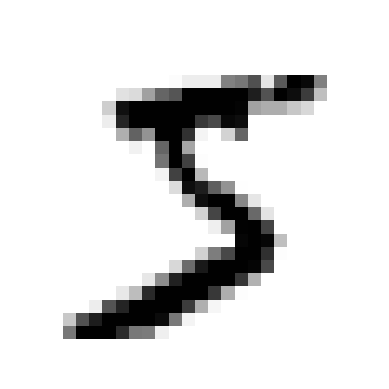

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
y = y.astype(np.uint8)

기존 레이블은 문자이다. 대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환한다.

또한 머신러닝을 위해서는 항상 테스트 세트를 만들고 따로 분류해놓아야 한다. MNIST 데이터셋은 이미 앞의 60000개의 훈련 세트와 뒤의 10000개의 테스트 세트로 나누어 놓았다.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련
문제를 단순화하여 하나의 숫자 5만 식별하기로 한다. 5-감지기는 '5'와 '5 아님' 2개의 클래스를 구분할 수 있는 **이진 분류기**의 하나의 예이다.

분류 작업을 위해 타겟 벡터를 만든다.

In [ ]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

하나의 분류 모델을 선택하여 훈련한다.

먼저 사이킷런의 **SGDClassifier** 클래스를 사용하여 **확률적 경사 하강법(SGD) 분류기**를 사용한다.

이 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 가진다. 이는 SGD가 한번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문이다.

SGDClassifier 모델을 만들고 전체 훈련 세트를 사용하여 훈련시킨다.

이 모델을 사용하여 숫자 5의 이미지를 감지하면, 분류기는 이 이미지가 5를 나타낸다고 추측한다.(True)


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정
분류기 평가는 회귀 모델보다 훨씬 더 어렵다. 또한 사용할 수 있는 성능 지표가 많다.

### 3.3.1 교차 검증을 사용한 정확도 측정
교차 검증은 모델을 평가하는 좋은 방법이다.

**k-겹 교차 검증**은 훈련 세트를 k개의 폴드로 나누어서 각 폴드에 대한 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다.

`cross_val_score()` 함수로 폴드가 3개인 k-겹 교차 검증을 사용하여 SGDClassifier 모델을 평가한다.

그 결과 모든 교차 검증 폴드에 대해 **정확도**(accuracy)가 95% 이상이다.

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

반대로 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교한다.

이 분류기의 정확도는 90% 이상이 되는데, 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%이기 때문이다.

이는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다. 특히 어떤 클래스가 다른 것보다 월등히 많은 불균형한 데이터셋을 다룰 때 더욱 그렇다.



In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 3.3.2 오차 행렬
분류기의 성능을 평가하는 더 좋은 방법은 **오차 행렬**을 조사하는 것이다. 기본 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다.

오차 행렬을 만드려면 실제 타겟과 비교할 수 있도록 먼저 예측 값을 만들어야 한다. 테스트 세트로 예측을 만들 수 있지만, 테스트 세트는 분류기가 출시 준비를 마치고 나서 프로젝트의 가장 마지막에 사용되므로 여기서 사용하면 안된다.

대신에 `cross_val_predict()` 함수를 사용할 수 있다. cross_val_score() 함수처럼 k-겹 교차 검증을 수행하지만, 평가 점수를 반환하지 않고 **각 테스트 폴드에서 얻은 예측을 반환**한다.


In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

`confusion_matrix()` 함수를 사용하여 오차 행렬을 만든다. 함수에 타겟 클래스(y_train_5)와 예측 클래스(y_train_pred)를 넣고 호출한다.

오차 행렬의 **행은 실제 클래스**를 나타내고 **열은 예측한 클래스**를 나타낸다.

첫번째 행은 '5 아님' 이미지에 대한 것으로 첫번째 열만큼 '5 아님'으로 정확하게 분류(진짜 음성)했고, 두번째 열만큼 '5'라고 잘못 분류(거짓 양성)했다.

두번째 행은 '5' 이미지에 대한 것으로 첫번째 열만큼 '5 아님'으로 잘못 분류(거짓 음성)했고, 두번째 열만큼 '5'라고 정확하게 분류(진짜 양성)했다.

완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이므로 오차 행렬의 주대각선만 0이 아닌 값이 된다.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
#완벽한 분류기
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

오차 행렬보다 더 요약된 지표가 필요한 경우가 있다. 살펴볼 만한 것 중 하나가 **양성 예측의 정확도**로, 이를 분류기의 **정밀도**라고 한다.

TP가 진짜 양성의 수, FP가 거짓 양성의 수라고 할 때, 정밀도는 TP/(TP+FP)이다.

정밀도는 **재현율**이라는 또 다른 지표와 같이 사용하는 것이 일반적인데, 재현율은 **분류기가 정확하게 감지한 양성 샘플의 비율**이다. 민감도 또는 진짜 양성 비율(TPR)이라고도 한다.

FN이 거짓 음성의 수라고 할 때, 재현율은 TP/(TP+FN)이다.

### 3.3.3 정밀도와 재현율
사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공한다.

정밀도와 재현율을 **F1 score**라는 하나의 숫자로 만들면 두 분류기를 비교할 때 편리하다. F1 score는 **정밀도와 재현율의 조화 평균**이다.

정밀도와 재현율이 비슷한 분류기에서는 F1 score가 높다. 하지만 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있으므로 항상 바람직한 것은 아니다.

정밀도와 재현율을 모두 얻을 수는 없다. 정밀도를 올리면 재현율이 줄어들며, 재현율을 올리면 정밀도가 줄어든다. 이를 **정밀도/재현율 트레이드오프**라고 한다.

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 트레이드오프
SGDClassifier 분류기는 결정 함수를 사용하여 각 샘플의 점수를 계산한다. 이 점수가 임계값보다 크면 샘플을 양성 클래스에 할당하고, 임계값보다 작으면 음성 클래스에 할당한다.

사이킷런에서 임계값을 직접 지정할 수는 없지만 **예측에 사용한 점수**를 확인할 수 있다. 분류기의 `predict()` 메서드 대신에 `decision_function()` 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다.

SGDClassifier의 임계값이 0이므로 threshold를 0으로 하면 `predict()` 메서드와 같은 결과를 반환한다.

반면 임계값을 높이면 분류기가 감지하지 못하게 된다. 이는 재현율이 줄어든다는 것을 보여준다.


In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

**적절한 임계값**을 정하기 위해서는 먼저 `cross_val_predict()` 함수를 사용하여 **훈련 세트에 있는 모든 샘플의 점수**를 구해야 한다. 하지만 이때 예측 결과가 아닌 **결정 점수를 반환**하도록 지정해야 한다.


In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

이렇게 구한 점수로 `precision_recall_curve()` 함수를 사용하여 가능한 모든 임계값에 대해 정밀도와 재현율을 계산할 수 있다.

맷플롯립을 이용하여 임계값에 대한 함수로 정밀도와 재현율을 그릴 수 있다.

이때 정밀도 곡선은 재현율 곡선보다 더 울퉁불퉁한데, 이는 임계값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문이다. 반면 재현율은 임계값이 올라감에 따라 줄어들 수밖에 없으므로 부드러운 곡선이 된다.

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

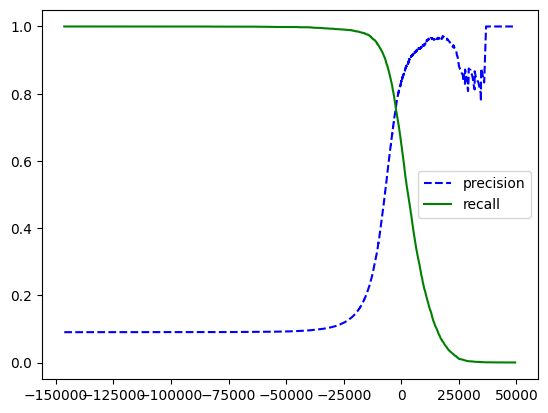

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.legend()
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것이다.

**정밀도가 급격하게 줄어들기 시작**하는 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.


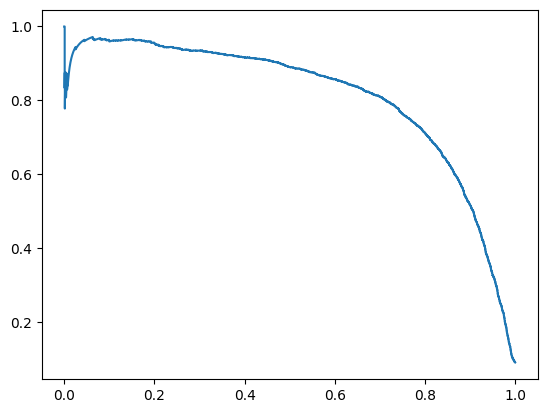

In [ ]:
plt.plot(recalls, precisions)
plt.show()

### 3.3.5 ROC 곡선
**ROC(수신기 조작 특성) 곡선**은 이진 분류에서 널리 사용하는 도구이다.

정밀도/재현율 곡선과 매우 비슷하지만, ROC 곡선은 **거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR, 재현율)의 곡선**이다.

양성으로 잘못 분류된 음성 샘플의 비율이 FPR로, 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 TNR을 뺀 값이다. TNR을 특이도라고도 하므로, ROC 곡선은 **재현율(민감도)에 대한 1-특이도의 그래프**이다.

ROC 곡선을 그리려면 `roc_curve()` 함수를 사용하여 여러 임계값에서 TPR과 FPR을 계산해야 한다.



In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

맷플롯립을 이용하여 FPR에 대한 TPR 곡선을 나타낼 수 있다.

이때에도 트레이드오프가 존재하는데, 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성 비율(FPR)이 늘어난다.

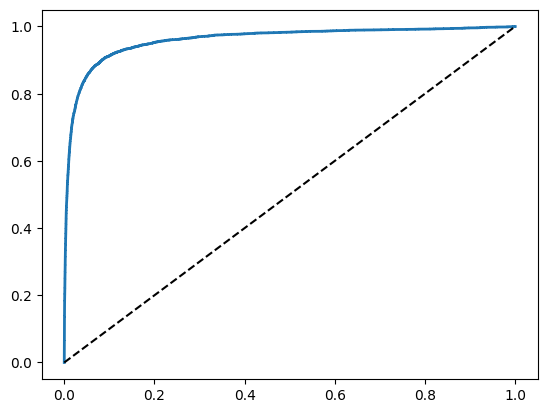

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")

plot_roc_curve(fpr, tpr)

이때 그래프에서 점선은 완전한 랜덤 분류기의 ROC 곡선을 의미한다. 좋은 분류기는 이 **점선에서 최대한 멀리** 떨어져 있어야 한다.

**곡선 아래의 면적(AUC)**을 측정하면 분류기들을 비교할 수 있다. 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5이다.

사이킷런은 ROC의 AUC를 계산하는 함수를 제공한다.

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier를 훈련시켜서 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교한다.

마찬가지로 먼저 훈련 세트의 샘플에 대한 점수를 얻어야 하지만, 작동 방식의 차이로 RandomForestClassifier에는 `decision_function()` 메서드가 없다.

대신에 `predict_proba()` 메서드를 가지고 있다. 이는 샘플이 행, 클래스가 열이고 **샘플이 주어진 클래스에 속할 확률**을 담은 배열을 반환한다.

사이킷런 분류기는 일반적으로 이 두가지 메서드 `decision_function()`와 `predict_proba()` 중 하나 또는 둘 모두를 가지고 있다.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

`roc_curve()` 함수는 레이블과 점수를 기대한다. 하지만 점수 대신 클래스 확률을 전달할 수 있다.

여기서는 양성 클래스 확률을 점수로 사용하여 FPR과 TPR을 구하고, 이를 이용하여 ROC 곡선을 그린다. 비교를 위해 이전의 ROC 곡선도 함께 그린다.

그림에서 볼 수 있듯이 RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까우므로 SGDClassifier보다 훨씬 좋아 보인다. 당연히 ROC AUC 점수도 더 높다.

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

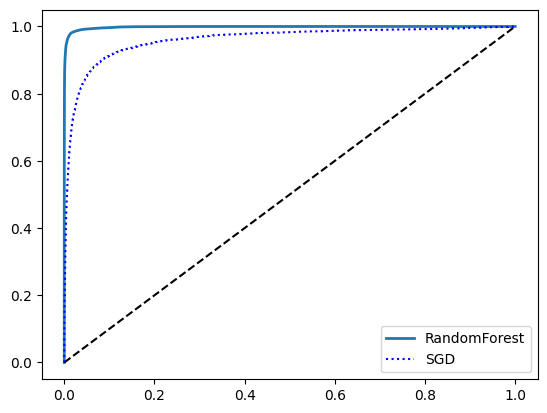

In [ ]:
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.plot(fpr, tpr, "b:", label="SGD")
plt.legend(loc="lower right")
plt.show()

## 3.4 다중 분류
이진 분류가 두 개의 클래스를 구별하는 반면 **다중 분류기**는 **둘 이상의 클래스를 분류**할 수 있다.

일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있는 반면, 로지스틱 회귀나 SVM 같은 알고리즘은 이진 분류만 가능하다. 이런 경우에는 이진 분류기를 여러 개 사용하여 다중 클래스를 분류하는 기법도 많다.

이런 경우 분류할 때 여러 개의 이진 분류기를 만들어서 **각 분류기의 결정 점수 중에서 가장 높은 것**을 선택할 수 있는데, 이를 **OvR 전략**이라고 한다. 대부분의 이진 분류 알고리즘에서 OvR 전략을 선호한다.

또 다른 전략으로는 **N개의 클래스가 있을 때 2개씩 조합**하여 Nx(N-1)/2개의 이진 분류기를 훈련 시키는 것으로, 이를 **OvO 전략**이라고 한다. 이 전략은 각 분류기를 훈련시킬 때, 전체 훈련 세트 중에서 구별할 두 클래스에 해당하는 샘플만 필요하다는 장점이 있다.

다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 전략 또는 OvO 전략을 실행한다.

사이킷런의 SVC 클래스를 사용하여 서포트 벡터 머신 분류기를 테스트한다. MNIST 예제에서는 10개의 클래스가 존재하므로 45개의 분류기를 훈련시켜야 한다.

훈련된 모델이 정확한 예측을 수행하는 것을 확인할 수 있다.

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

 내부에서는 사이킷런이 OvO 전략을 사용하여 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 가장 높은 클래스를 선택한다.

`decision_function()` 메서드를 호출하면 샘플당 10개의 점수를 반환한다. 각 클래스마다 하나씩의 점수이다.

6번째 값이 가장 크며, 이 점수가 클래스 5에 해당하는 값이다.



In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 multiclass로부터 OneVsOneClassifier나 OneVsRestClassifier를 사용한다. 간단하게 이진 분류기 인스턴스를 만들어서 객체를 생성할 때 전달하면 된다.

다음 코드는 SVC 기반으로 OvR 전략을 사용하는 다중 분류기를 만든다.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

SGDClassifier를 훈련시키는 것도 간단하다. SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도의 OvR이나 OvO를 적용할 필요가 없다.

`decision_function()` 메서드를 이용하여 SGD 분류기가 클래스마다 부여한 점수를 확인한다.

클래스 5의 점수만 큰 양수이고, 나머지 클래스의 점수는 큰 음수이므로 분류기가 예측 결과에 강한 확신을 보이고 있음을 알 수 있다.

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

분류기를 평가하기 위해서는 일반적으로 교차 검증을 사용한다.

`cross_val_score()` 함수를 사용하여 SGDClassifier의 정확도를 평가한다.

모든 테스트 폴드에서 나쁘지 않은 정확도를 얻었지만, 간단하게 입력 스케일을 조정하면 정확도를 향상시켜 성능을 더 높일 수도 있다.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석
가능성이 높은 모델을 찾은 경우, 이 모델의 성능을 향상시키는 한가지 방법은 만들어진 에러의 종류를 분석하는 것이다.

먼저 오차 행렬을 살펴볼 수 있다. `cross_val_predict()` 함수를 사용해 예측을 만들고, `confusion_matrix()` 함수를 호출한다.

많은 숫자가 출력되므로, 맷플롯립의 `matshow()` 함수를 사용하여 이미지로 표현하면 보기에 더 편리하다.

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

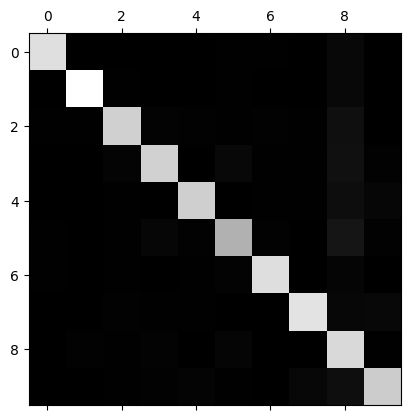

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

맷플롯립으로 오차 행렬을 그리면 배열에서 **가장 큰 값은 흰색**으로, **가장 작은 값은 검은색**으로 정규화되어 그려진다. 이 오차 행렬은 대부분의 흰색이 주대각선에 있으므로 이미지가 올바르게 분류되었다고 볼 수 있다.

클래스 5는 다른 대각선보다 조금 더 어두워보이는데, 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻이다.

그래프의 에러 부분에 초점을 맞추기 위해서 먼저 **오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교**한다. 에러의 절대 개수로 비교하면 이미지가 많은 클래스가 상대적으로 더 나쁘게 보이므로 에러 비율을 이용한다.


In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 다시 그린다.

행은 실제 클래스를 나타내고, 열은 예측한 클래스를 나타낸다. 클래스 8의 열이 상당히 밝은 것으로 보아 많은 이미지가 클래스 8로 잘못 예측되었음을 암시한다.

반면 클래스 8의 행은 그리 나쁘지 않은 것으로 보아 실제 8은 클래스 8로 적절하게 분류되었다는 것을 의미한다.

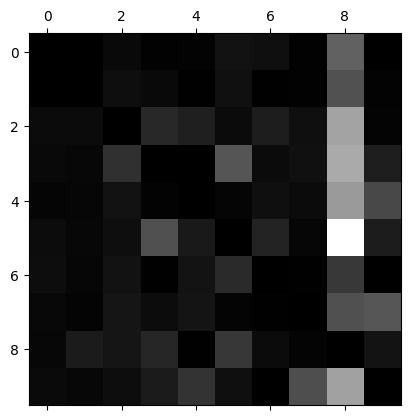

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있다. 이 그래프의 경우에는 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다.

예를 들어 실제 8은 아니지만 8처럼 보이는 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분할 수 있도록 분류기를 학습시킬 수 있다.

또는 분류기에 도움이 될 만한 특성을 더 찾아보는 것도 좋은 방법이다.

## 3.6 다중 레이블 분류
지금까지는 각 샘플이 하나의 클래스에만 할당되었지만, 분류기가 샘플마다 여러 개의 클래스를 출력해야할 때도 있다.

여러 개의 이진 꼬리표를 출력하는 분류 시스템을 **다중 레이블 분류** 시스템이라고 한다.

다음의 코드는 각 숫자 이미지에 2개의 타겟 레이블이 담긴 y_multilabel 배열을 만든다. 첫번째는 숫자가 큰 값(7,8,9)인지를 나타내고, 두번째는 홀수인지를 나타낸다.

그 다음은 KNeighborsClassifier 인스턴스를 만들고, 다중 타겟 배열을 사용하여 훈련시킨다. 이 모델에 예측을 만들면 레이블이 2개 출력된다.

숫자 5는 크지 않고(False), 홀수(True)이다.

In [ ]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

다중 레이블 분류기를 평가하는 방법은 많으므로, 프로젝트에 따라 적절한 지표를 사용하면 된다.

예를 들어 각 레이블의 F1 score를 구하고, 간단하게 평균 점수를 계산할 수 있다.

다음 코드는 모든 레이블에 대한 F1 score의 평균을 계산한다.

만약에 특정 레이블이 훨씬 많다면 해당 클래스에 대한 분류기의 점수에 더 높은 가중치를 둘 수 있다. 간단한 방법은 레이블에 클래스의 지지도(타겟 레이블에 속한 샘플 수)를 가중치로 주는 것이다. 코드에서 `average="weighted"`로 설정하면 된다.


In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## 3.7 다중 출력 분류
**다중 출력 다중 클래스 분류**는 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것이다. 즉 값을 2개 이상 가질 수 있다.

이를 위해 이미지에서 잡음을 제거하는 시스템을 만들 것이다.

잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력한다. 분류기의 출력이 다중 레이블이고 각 레이블은 0부터 255까지의 픽셀 강도로 여러 개의 값을 갖는다. 그러므로 다중 출력 분류 시스템이 된다.

먼저 MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 `randint()` 함수를 사용하여 픽셀 강도에 잡음을 추가한다.

타겟 이미지는 원본 이미지이다.

분류기를 훈련시켜 이 이미지를 깨끗하게 만들어본다.

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

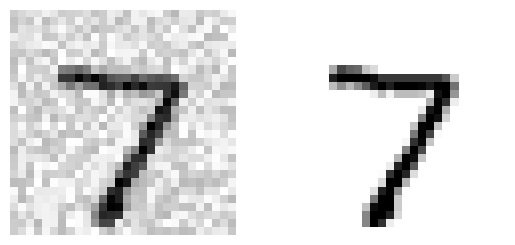

In [ ]:
some_index = 0
plt.subplot(121)
plot_digit(X_test_mod[some_index])
plt.subplot(122)
plot_digit(y_test_mod[some_index])
plt.show()

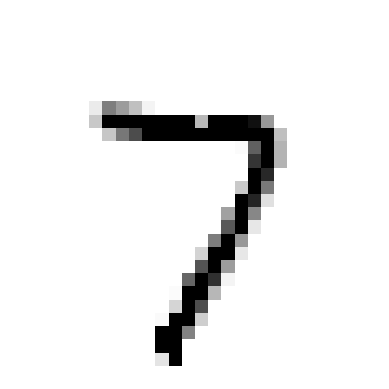

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)